In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
df=pd.read_csv("clothing.csv",parse_dates=True,index_col='DATE')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 1992-01-01 to 2019-11-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   MRTSSM448USN  335 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [42]:
df.columns=["Sales"]

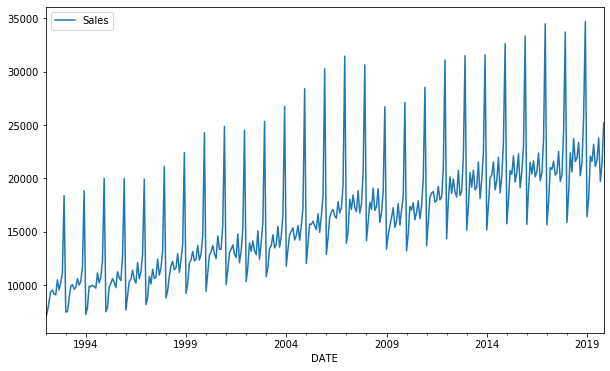

In [43]:
df.plot(figsize=(10,6))

In [44]:
test_size=18
test_ind=len(df)-test_size

In [45]:
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [47]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [48]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [49]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [50]:
length=12
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [51]:
X,y=generator[0]
len(X[0])

12

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
n_features=1

In [53]:
model=Sequential()
model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor="val_loss",patience=2)

In [56]:
validation_generator=TimeseriesGenerator(scaled_test,scaled_test,
                                        length=length,batch_size=1)


In [57]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
305/305 [==============================] - 9s 31ms/step - loss: 0.0239 - val_loss: 0.0047
Epoch 2/20
305/305 [==============================] - 8s 27ms/step - loss: 0.0167 - val_loss: 0.0065
Epoch 3/20
305/305 [==============================] - 8s 27ms/step - loss: 0.0127 - val_loss: 0.0010
Epoch 4/20
305/305 [==============================] - 7s 22ms/step - loss: 0.0076 - val_loss: 0.0026
Epoch 5/20
305/305 [==============================] - 6s 20ms/step - loss: 0.0033 - val_loss: 0.0031


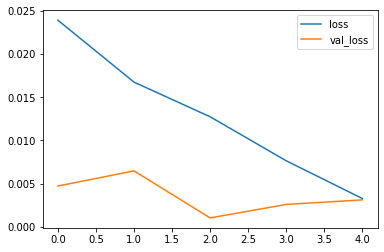

In [58]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [59]:
test_predictions=[]

first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [60]:
true_predictions=scaler.inverse_transform(test_predictions)

In [61]:
test["Predictions"]=true_predictions

C:\Users\Havva\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
test

,Sales,Predictions
DATE,,
2018-06-01,21589,21223.183245
2018-07-01,21919,21561.897682
2018-08-01,23381,23270.853068
2018-09-01,20260,21059.850430
2018-10-01,21473,21807.055335
2018-11-01,25831,25592.396398
2018-12-01,34706,36096.520265
2019-01-01,16410,17431.642112
2019-02-01,18134,19701.374264


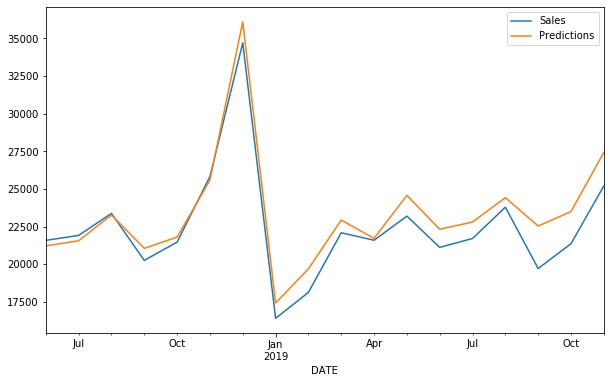

In [63]:
test.plot(figsize=(10,6))

In [64]:
full_scaler=MinMaxScaler()
scaled_full_data=full_scaler.fit_transform(df)

In [65]:
length=12
generator=TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [66]:
model=Sequential()
model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")
model.fit_generator(generator,epochs=8)

Epoch 1/8
323/323 [==============================] - 9s 29ms/step - loss: 0.0276
Epoch 2/8
323/323 [==============================] - 6s 19ms/step - loss: 0.0175
Epoch 3/8
323/323 [==============================] - 6s 19ms/step - loss: 0.0122
Epoch 4/8
323/323 [==============================] - 6s 20ms/step - loss: 0.0069
Epoch 5/8
323/323 [==============================] - 6s 20ms/step - loss: 0.0027
Epoch 6/8
323/323 [==============================] - 6s 19ms/step - loss: 0.0018
Epoch 7/8
323/323 [==============================] - 6s 19ms/step - loss: 0.0019
Epoch 8/8
323/323 [==============================] - 6s 20ms/step - loss: 0.0017: 0s - 


In [67]:
forecast=[]
periods=12

first_eval_batch=scaled_full_data[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    current_pred=model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [68]:
forecast=scaler.inverse_transform(forecast)

In [69]:
forecast_index=pd.date_range(start="2019-11-01",periods=periods,freq="MS")

In [70]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [71]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,columns=["Forecast"])

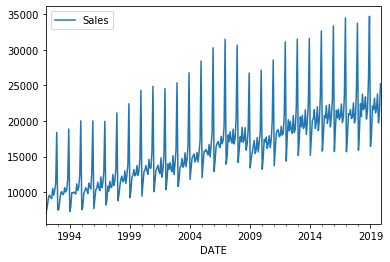

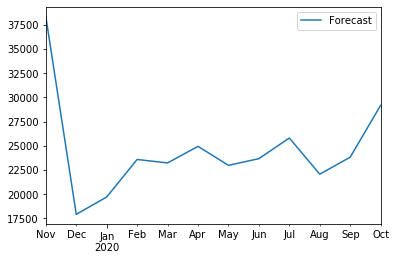

In [72]:
df.plot()
forecast_df.plot()

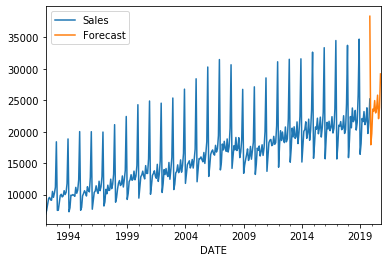

In [75]:
ax=df.plot()
forecast_df.plot(ax=ax)

(576, 611)

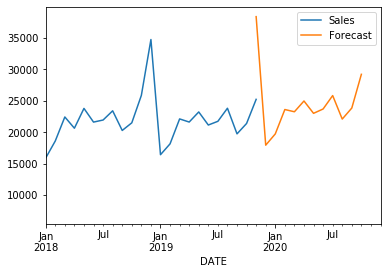

In [76]:
ax=df.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018.01.01","2020-12-01")